In [1]:
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
import tellurium as te

import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

### To show that each iteration on the same dataset is statistically the same (ANOVA)

In [ ]:
######### USER-INPUT SECTION
MODEL_FILE_PATH = '../data/interim/Antimony/Simplified_Teusink_yeast.ant'
iteration_folder = '../data/interim/generated_data/simplTeusink-noReg/iterations/'
######### END OF USER-INPUT SECTION

model = te.loada(MODEL_FILE_PATH)
gt=model.getScaledElasticityMatrix().flatten()

# Establish labels for metabolite and reaction names
m_labels = [m for m in model.getFloatingSpeciesIds()]
r_labels = [r for r in model.getReactionIds()]

ex_labels = np.array([['$\epsilon_{' + '{0},{1}'.format(rlabel, mlabel) + '}$'
                    for mlabel in m_labels] for rlabel in r_labels]).flatten()

ex_file_labels = np.array([['E_' + '{0},{1}'.format(rlabel, mlabel)
                    for mlabel in m_labels] for rlabel in r_labels]).flatten()

# load the predicted Ex dataset
# then reshape into 1000 rows, 176 columns
# plot all data in each column as a scatter plot
# make a plotting method
def run_ANOVA10(colNo, exs101):
    only_iter = []
    for df in exs101:
        only_iter.append(df.loc[:,ex_labels[colNo]])
        # sns.swarmplot(data=df, x=ex_labels[colNo], size=3, alpha=0.8)
    # run ANOVA
    return f_oneway(*only_iter)


def plot_heatmaps(pt_lvl):
    exs101 = []
    for folder in os.listdir(iteration_folder):
        ex101=pd.read_csv(iteration_folder + folder +f'/{pt_lvl}x_PredictedExs.csv', index_col=0).values
        exs101.append(pd.DataFrame(ex101.reshape(1000,176), columns=ex_labels))
    
    fdict= {}
    for i in range(len(ex_labels)):
        fdict[ex_labels[i]]= [run_ANOVA10(i, exs101)[0]]

    a = pd.DataFrame.from_dict(fdict).T
    a['id'] = [idx.strip('$\epsilon_{}') for idx in a.index]
    a.reset_index()
    a['reaction'] = [i.split(',')[0] for i in a['id']]
    a['metabolite'] = [i.split(',')[1] for i in a['id']]
    a.set_index('id', inplace=True)
    a.rename(columns={0:'f-stat'}, inplace=True)
    b = pd.pivot(a, values='f-stat', index='reaction', columns='metabolite')

    sns.heatmap(b, norm=LogNorm())
    plt.title(f'ANOVA f-scores for BMCA iterations of {pt_lvl}x perturbation of data')
    plt.savefig(f'anova_fscores_{pt_lvl}.png')
    plt.close()

In [ ]:
pt = [0.1, 0.2, 0.3, 0.4, 0.5, 1.01, 1.5, 3, 5, 7, 10]
for lvl in pt:
    plot_heatmaps(lvl)


# Topology A--Visualizing Spearman data 

### Condensing all the spearman r data

In [2]:
os.chdir('../data/results/spearman_coefficients/')

In [3]:
spr_file_list = [i for i in os.listdir() if "topologyA" in i]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[1]
    omit = file.split('_')[2]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_A = pd.concat(spr_dfs)
all_spr_df_A

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x,0.550000,0.033655,0.074636,0.821687,noReg,none
1,0.2x,0.610714,0.015593,0.164933,0.849308,noReg,none
2,0.3x,0.750000,0.001281,0.404777,0.908097,noReg,none
3,0.4x,0.896429,0.000006,0.721193,0.963839,noReg,none
4,0.5x,0.917857,0.000001,0.774568,0.971530,noReg,none
...,...,...,...,...,...,...,...
6,1.5x,0.796429,0.000380,0.496886,0.926399,reg2,omitIntMet
7,3x,0.339286,0.216029,-0.188056,0.714781,reg2,omitIntMet
8,5x,0.160714,0.567197,-0.363998,0.607990,reg2,omitIntMet
9,7x,0.489286,0.064160,-0.008485,0.792727,reg2,omitIntMet


In [4]:
os.chdir('../../../notebooks/')

In [5]:
all_spr_df_A.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_A['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_A['perturbation']]

In [6]:
a = all_spr_df_A.pivot(index=['omit', 'reg'], columns='perturbation', values='r')
a

perturbation          0.10      0.20      0.30      0.40      0.50      1.01   \
omit        reg                                                                 
none        noReg  0.550000  0.610714  0.750000  0.896429  0.917857  0.578571   
            reg1   0.600000  0.714286  0.807143  0.807143  0.810714  0.185714   
            reg2   0.625000  0.514286  0.639286  0.632143  0.625000  0.389286   
omitEnzymes noReg -0.203571  0.089286  0.610714  0.582143  0.821429  0.278571   
            reg1   0.175000  0.342857  0.610714  0.614286  0.492857  0.017857   
            reg2  -0.067857  0.207143  0.271429  0.771429  0.689286  0.175000   
omitExMet   noReg  0.553571  0.621429  0.739286  0.867857  0.935714  0.317857   
            reg1   0.557143  0.560714  0.696429  0.710714  0.850000  0.103571   
            reg2   0.553571  0.628571  0.721429  0.628571  0.646429  0.264286   
omitFluxes  noReg  0.471429  0.482143  0.225000  0.082143  0.050000  0.775000   
            reg1   0.060714 -0.014286  0.035714  0.382143 -0.175000  0.539286   
            reg2   0.107143  0.003571  0.278571 -0.225000  0.382143  0.103571   
omitIntMet  noReg -0.035714 -0.192857  0.296429  0.064286  0.517857  0.642857   
            reg1   0.160714 -0.232143  0.053571  0.489286  0.792857  0.292857   
            reg2   0.203571  0.239286  0.217857  0.571429  0.846429  0.057143   

perturbation          1.50      3.00      5.00      7.00      10.00  
omit        reg                                                      
none        noReg  0.982143  0.957143  0.953571  0.925000  0.914286  
            reg1   0.760714  0.807143  0.839286  0.825000  0.864286  
            reg2   0.546429  0.646429  0.635714  0.771429  0.896429  
omitEnzymes noReg  0.953571  0.107143  0.282143  0.321429  0.303571  
            reg1   0.789286  0.685714  0.328571  0.321429  0.000000  
            reg2   0.660714  0.285714  0.528571  0.275000  0.064286  
omitExMet   noReg  0.950000  0.982143  0.960714  0.932143  0.942857  
            reg1   0.750000  0.685714  0.796429  0.800000  0.864286  
            reg2   0.510714  0.578571  0.642857  0.717857  0.846429  
omitFluxes  noReg  0.539286  0.117857  0.728571  0.703571  0.121429  
            reg1   0.146429  0.139286  0.135714  0.050000  0.010714  
            reg2   0.182143 -0.121429  0.442857  0.214286  0.239286  
omitIntMet  noReg  0.903571  0.950000  0.364286  0.410714  0.460714  
            reg1   0.789286  0.610714  0.907143  0.735714  0.489286  
            reg2   0.796429  0.339286  0.160714  0.489286  0.210714

In [7]:
all_spr_df_A

,perturbation,r,p-value,lower,upper,reg,omit
0,0.1,0.550000,0.033655,0.074636,0.821687,noReg,none
1,0.2,0.610714,0.015593,0.164933,0.849308,noReg,none
2,0.3,0.750000,0.001281,0.404777,0.908097,noReg,none
3,0.4,0.896429,0.000006,0.721193,0.963839,noReg,none
4,0.5,0.917857,0.000001,0.774568,0.971530,noReg,none
...,...,...,...,...,...,...,...
6,1.5,0.796429,0.000380,0.496886,0.926399,reg2,omitIntMet
7,3.0,0.339286,0.216029,-0.188056,0.714781,reg2,omitIntMet
8,5.0,0.160714,0.567197,-0.363998,0.607990,reg2,omitIntMet
9,7.0,0.489286,0.064160,-0.008485,0.792727,reg2,omitIntMet


In [8]:
fluxes_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2') & (all_spr_df_A['omit'].isin(['none', 'omitExMet']))]

In [9]:
def plt_spr_scatter(dataframe, title):
    plt = sns.scatterplot(data=dataframe, x='perturbation', y="r", hue='omit', style='omit', s=100, alpha=0.8, zorder=100)
    plt.grid(True, which='both', axis='both', zorder=0)
    plt.set(xscale='log')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.set_xlabel('fold change in enzyme concentration', size=14)
    plt.set_ylabel('Spearman rank coefficient, $\it{r}$', size=14)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.set_title(title, size=20)
    

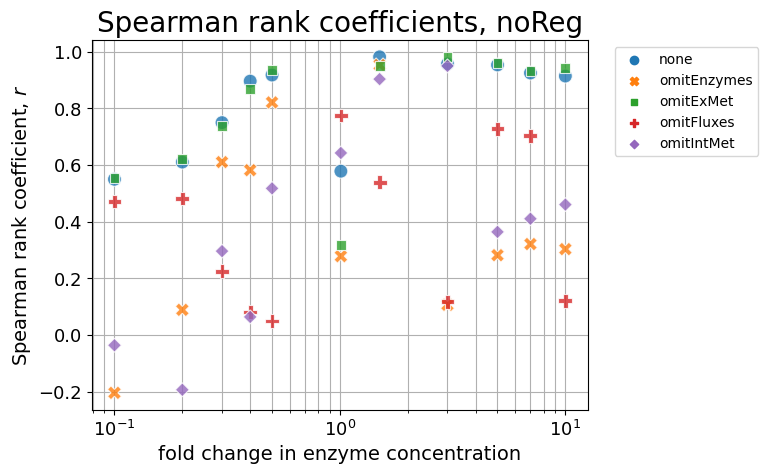

In [10]:
plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

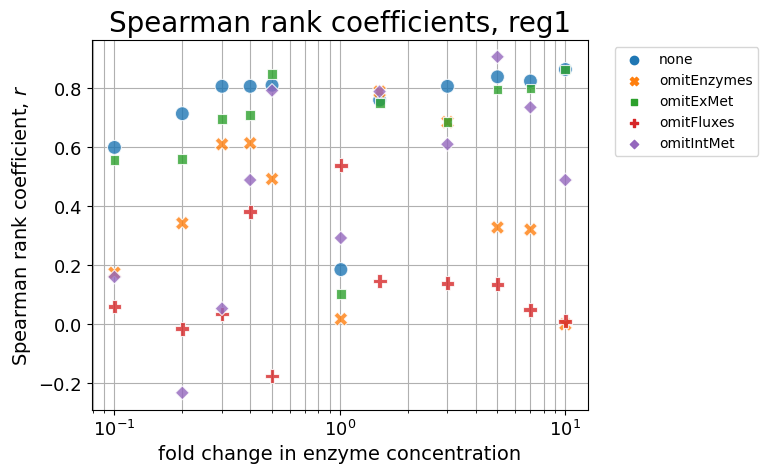

In [11]:
plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

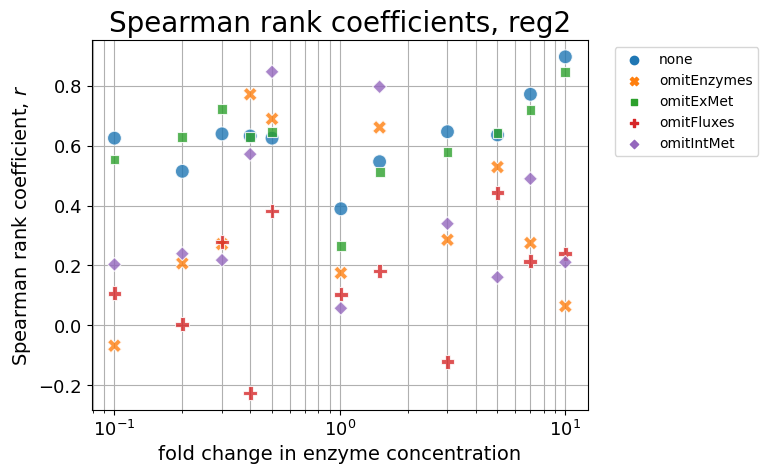

In [12]:
plt_spr_scatter(all_spr_df_A.loc[(all_spr_df_A['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Comparing Spearman r coefficients pairwise to find significant differences
My way of doing that would be to plot the confidence intervals around the
coefficients and compare them. 

Another testing option would be looking at the absolute difference in the ranks 
between a prediction method and the truth. You would have a sample of absolute 
rank differences for each method, but they would not independent (so can't use 
Kruskal-Wallis test). The samples of differences would be dependent ("paired" 
across methods by the observation/value being ranked). A test that you could use
is Friedman's test which is based on ranks (kind of like an extension of the 
Wilcoxon signed rank test for more than 2 "paired"/dependent samples). Post-hoc 
testing could be done using the Wilcoxon signed rank test and using Holm's or 
Bonferroni method to adjust the p-value for multiple testing.

In [13]:
def plot_CI_comparisons(omitted_type, reg_level, color='orange'):

    df1 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']=='none')]
    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    df2 = all_spr_df_A[(all_spr_df_A['reg']==reg_level) & (all_spr_df_A['omit']==f'omit{omitted_type}')]
    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    plt.scatter(df1['perturbation'] - 0.01*df1['perturbation'], 
                abs(df1['r']), alpha=0.8, s=100, zorder=100, label='all data', 
                color='red')
    plt.errorbar(df1['perturbation'] - 0.02*df1['perturbation'], df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red')

    plt.scatter(df2['perturbation'] + 0.01*df2['perturbation'], 
                abs(df2['r']), alpha=0.8, s=100, zorder=100, 
                label=f'omit {omitted_type}', c=color)
    plt.errorbar(df2['perturbation'] + 0.02*df2['perturbation'], df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 linestyle='None', c=color)


    plt.grid(True, which='both', axis='both', zorder=0)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel('change in enzyme concentration', size=14)
    plt.ylabel('Spearman rank coefficient, $\it{r}$', size=14)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.ylim((0,1))
    plt.title(f"Comparing datasets of no data withheld and \nwithholding of {omitted_type} data, {reg_level}", size=20)
    plt.show()
        

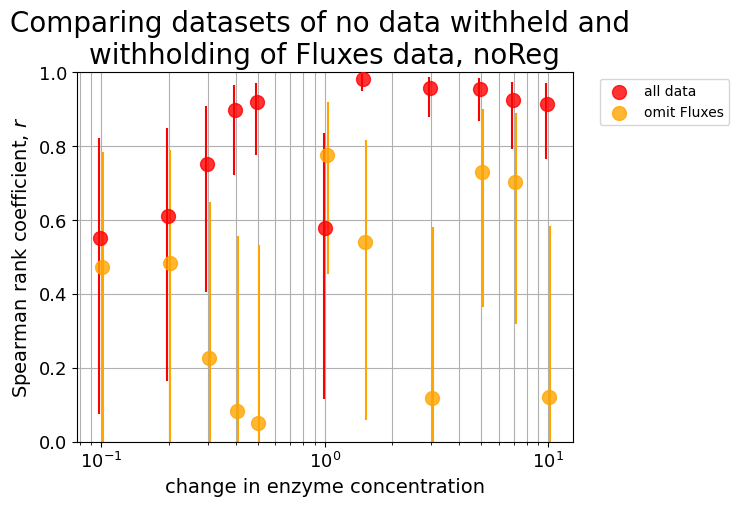

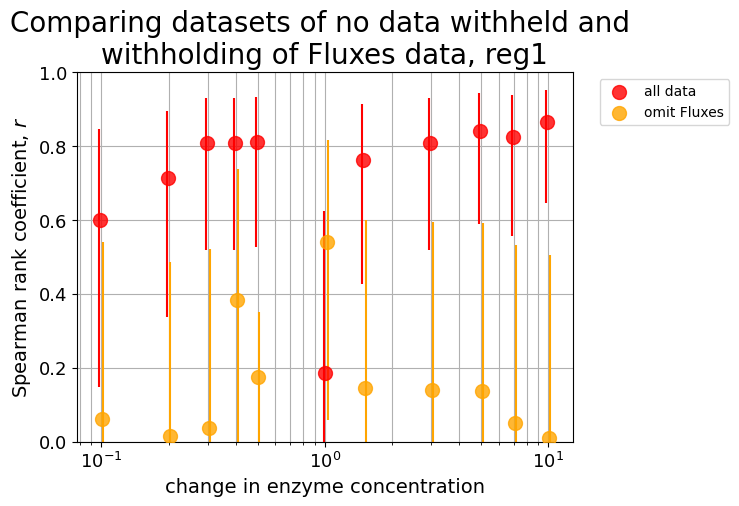

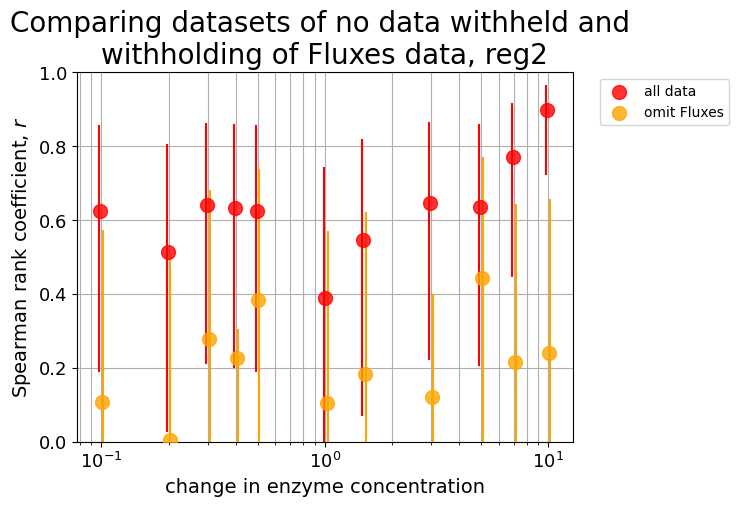

In [14]:
plot_CI_comparisons("Fluxes", "noReg")
plot_CI_comparisons("Fluxes", "reg1")
plot_CI_comparisons("Fluxes", "reg2")

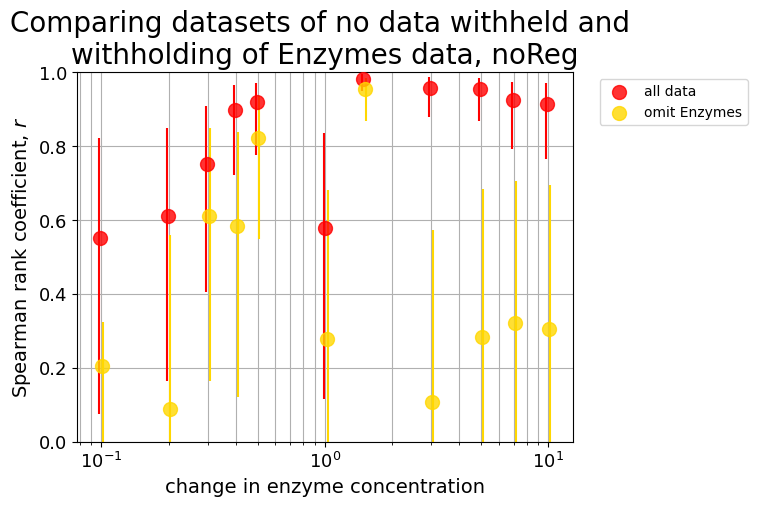

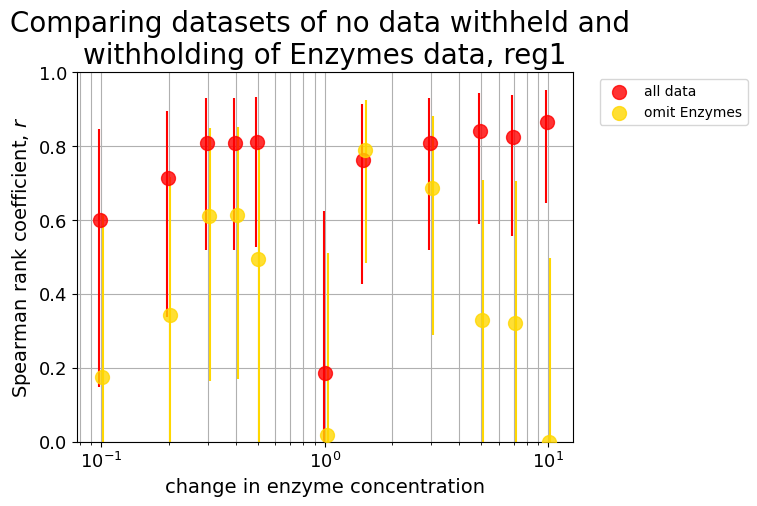

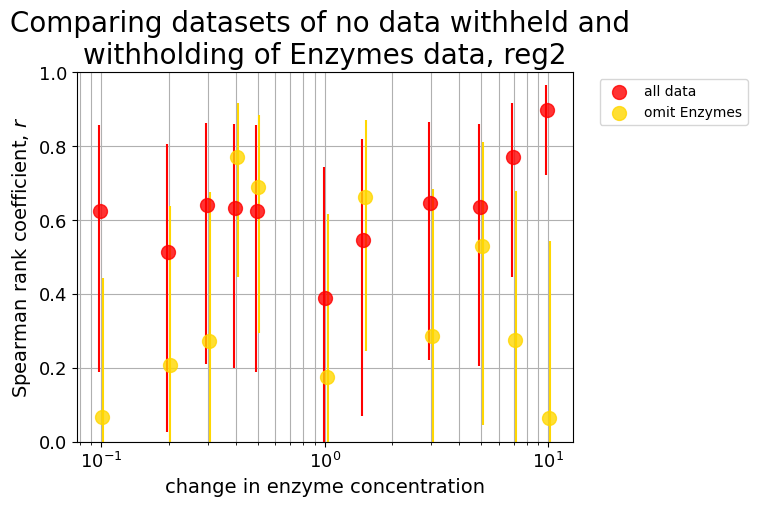

In [15]:
plot_CI_comparisons("Enzymes", "noReg", color='gold')
plot_CI_comparisons("Enzymes", "reg1", color='gold')
plot_CI_comparisons("Enzymes", "reg2", color='gold')


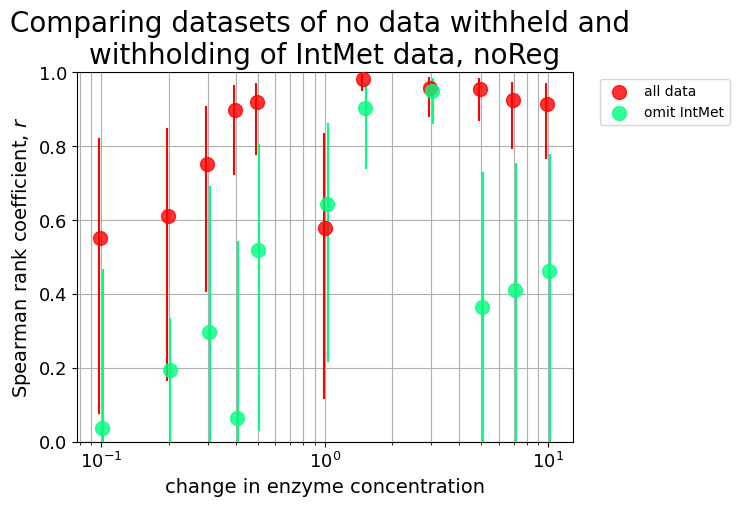

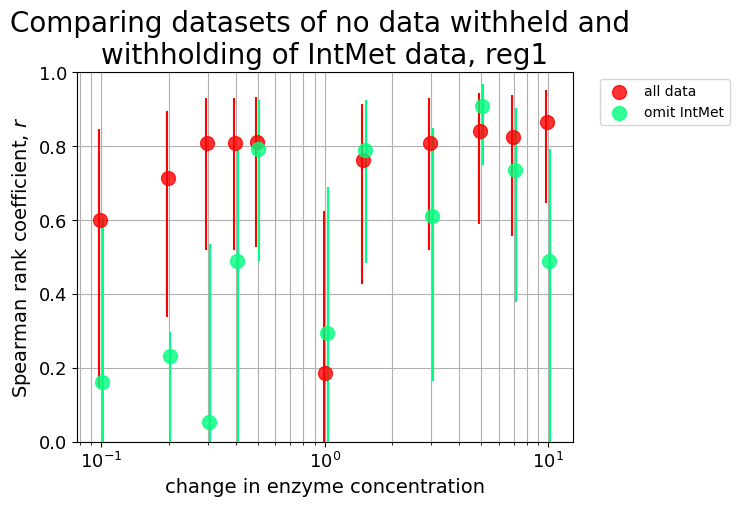

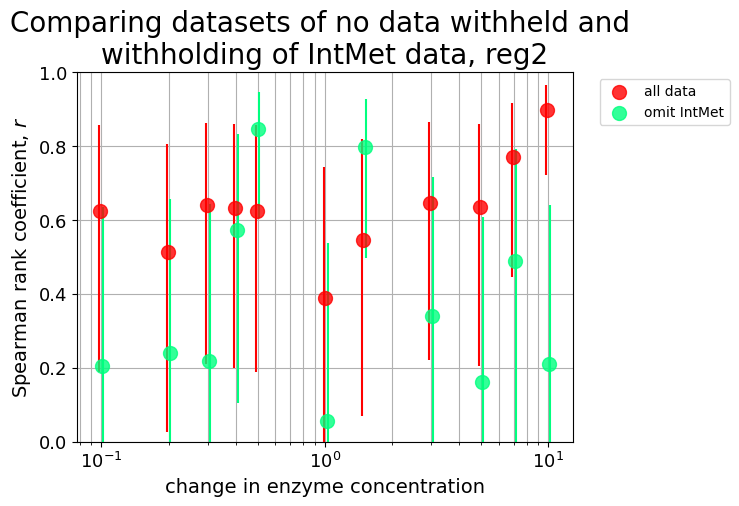

In [16]:
plot_CI_comparisons("IntMet", "noReg", color='springgreen')
plot_CI_comparisons("IntMet", "reg1", color='springgreen')
plot_CI_comparisons("IntMet", "reg2", color='springgreen')

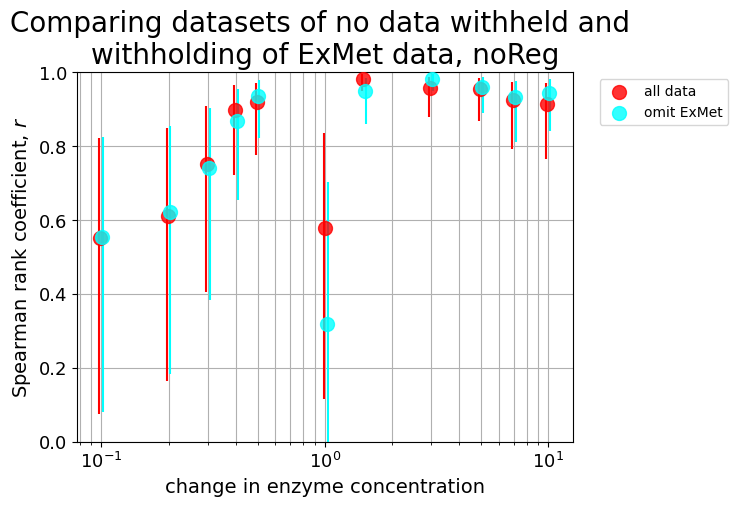

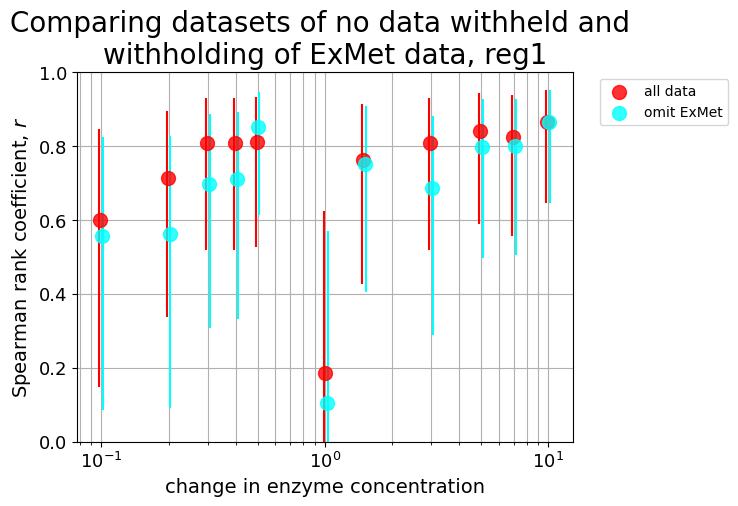

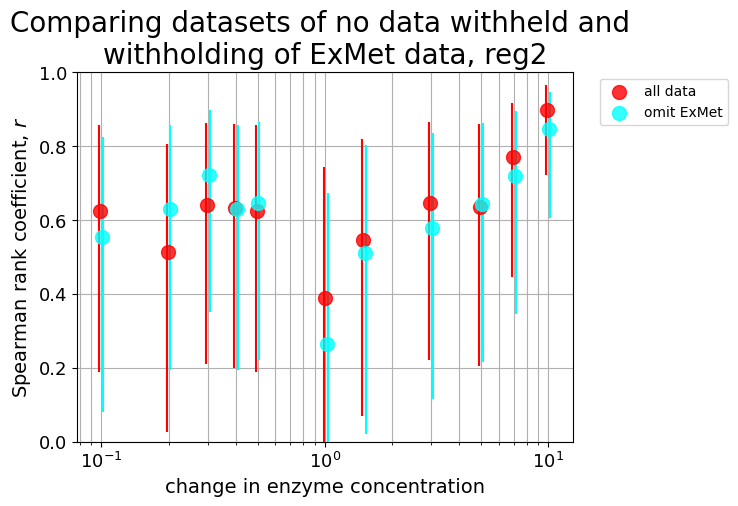

In [17]:
plot_CI_comparisons("ExMet", "noReg", color='cyan')
plot_CI_comparisons("ExMet", "reg1", color='cyan')
plot_CI_comparisons("ExMet", "reg2", color='cyan')

### comparing all data runs only

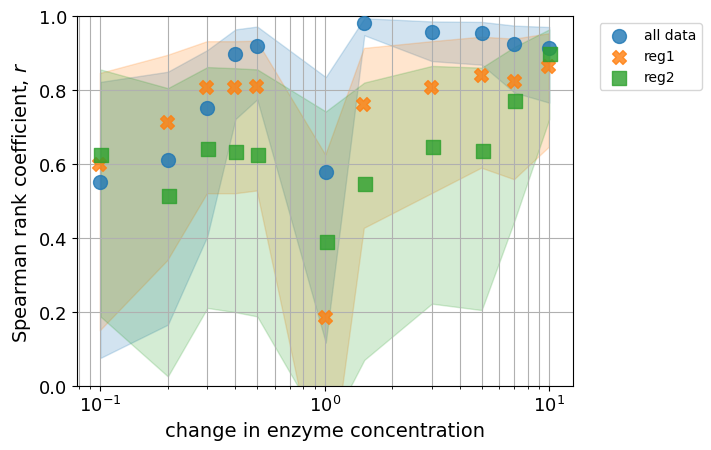

In [36]:
df1 = all_spr_df_A[(all_spr_df_A['reg']=='noReg') & (all_spr_df_A['omit']=='none')]
ymin1 = (df1['r'] - df1['lower']).values
ymax1 = (df1['upper'] - df1['r']).values

df2 = all_spr_df_A[(all_spr_df_A['reg']=='reg1') & (all_spr_df_A['omit']=='none')]
ymin2 = (df2['r'] - df2['lower']).values
ymax2 = (df2['upper'] - df2['r']).values

df3 = all_spr_df_A[(all_spr_df_A['reg']=='reg2') & (all_spr_df_A['omit']=='none')]
ymin3 = (df3['r'] - df3['lower']).values
ymax3 = (df3['upper'] - df3['r']).values


plt.scatter(df1['perturbation'], 
            abs(df1['r']), alpha=0.8, s=100, zorder=100, label='all data', 
            ) # color='red'
#plt.errorbar(df1['perturbation'] , df1['r'], yerr=np.stack((ymin1, ymax1)), 
#                 linestyle='None') # , color='red'
plt.fill_between(x=df1['perturbation'], y1=df1['lower'] , y2=df1['upper'], 
                 alpha=0.2, color='tab:blue')

plt.scatter(df2['perturbation'] - 0.01*df2['perturbation'], 
            abs(df2['r']), alpha=0.8, s=100, zorder=100, 
            label='reg1', marker='X') # c='salmon',
#plt.errorbar(df2['perturbation'] - 0.02*df2['perturbation'], df2['r'], yerr=np.stack((ymin1, ymax1)), 
#                 linestyle='None') # , color='salmon'
plt.fill_between(x=df2['perturbation'], y1=df2['lower'] , y2=df2['upper'], 
                 alpha=0.2, color='tab:orange')

plt.scatter(df3['perturbation'] + 0.01*df1['perturbation'], 
            abs(df3['r']), alpha=0.8, s=100, zorder=100, 
            label='reg2',  marker='s') # c="chocolate",
#plt.errorbar(df3['perturbation'] + 0.02*df1['perturbation'], df3['r'], yerr=np.stack((ymin1, ymax1)), 
#                 linestyle='None') # , color="chocolate"
plt.fill_between(x=df3['perturbation'], y1=df3['lower'] , y2=df3['upper'], 
                 alpha=0.2, color='tab:green')

plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('change in enzyme concentration', size=14)
plt.ylabel('Spearman rank coefficient, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim((0,1))
plt.title("", size=20)
plt.show()
    

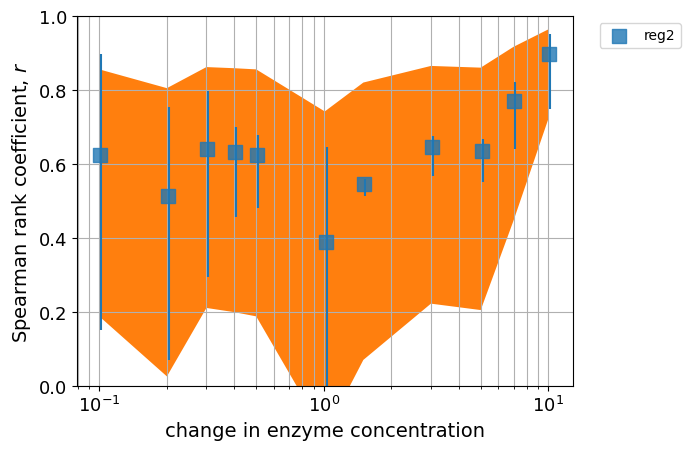

In [31]:
df3 = all_spr_df_A[(all_spr_df_A['reg']=='reg2') & (all_spr_df_A['omit']=='none')]
ymin3 = (df3['r'] - df3['lower']).values
ymax3 = (df3['upper'] - df3['r']).values


plt.scatter(df3['perturbation'] + 0.01*df1['perturbation'], 
            abs(df3['r']), alpha=0.8, s=100, zorder=100, 
            label='reg2',  marker='s') # c="chocolate",
plt.errorbar(df3['perturbation'] + 0.02*df1['perturbation'], df3['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None') # , color="chocolate"
plt.fill_between(x=df3['perturbation'], y1=df3['lower'] , y2=df3['upper'] )


plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('change in enzyme concentration', size=14)
plt.ylabel('Spearman rank coefficient, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim((0,1))
plt.title("", size=20)
plt.show()

# Topology B--Visualizing Spearman data 

In [26]:
os.chdir('../data/results/spearman_coefficients/')

In [27]:
spr_file_list = [i for i in os.listdir() if "topologyB" in i]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[1]
    omit = file.split('_')[2]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_B = pd.concat(spr_dfs)
all_spr_df_B

ValueError: No objects to concatenate

In [ ]:
os.chdir('../../../notebooks/')

In [ ]:
all_spr_df_B.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_B['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_A_B['perturbation']]

In [ ]:
b = all_spr_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='r')
b

In [ ]:
fluxes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitExMet']))]

In [ ]:
plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

In [ ]:
plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

In [ ]:
plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Comparing Spearman r coefficients pairwise to find significant differences

In [ ]:
def plot_CI_comparisons(omitted_type, reg_level, color='orange'):

    df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='none')]
    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_A['omit']==f'omit{omitted_type}')]
    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    plt.scatter(df1['perturbation'] - 0.01*df1['perturbation'], 
                abs(df1['r']), alpha=0.8, s=100, zorder=100, label='all data', 
                color='red')
    plt.errorbar(df1['perturbation'] - 0.02*df1['perturbation'], df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red')

    plt.scatter(df2['perturbation'] + 0.01*df2['perturbation'], 
                abs(df2['r']), alpha=0.8, s=100, zorder=100, 
                label=f'omit {omitted_type}', c=color)
    plt.errorbar(df2['perturbation'] + 0.02*df2['perturbation'], df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 linestyle='None', c=color)


    plt.grid(True, which='both', axis='both', zorder=0)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel('change in enzyme concentration', size=14)
    plt.ylabel('Spearman rank coefficient, $\it{r}$', size=14)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.ylim((0,1))
    plt.title(f"Comparing datasets of no data withheld and \nwithholding of {omitted_type} data, {reg_level}", size=20)
    plt.show()
        

In [ ]:
plot_CI_comparisons("Fluxes", "noReg")
plot_CI_comparisons("Fluxes", "reg1")
plot_CI_comparisons("Fluxes", "reg2")

In [ ]:
plot_CI_comparisons("Enzymes", "noReg", color='gold')
plot_CI_comparisons("Enzymes", "reg1", color='gold')
plot_CI_comparisons("Enzymes", "reg2", color='gold')


In [ ]:
plot_CI_comparisons("IntMet", "noReg", color='springgreen')
plot_CI_comparisons("IntMet", "reg1", color='springgreen')
plot_CI_comparisons("IntMet", "reg2", color='springgreen')

In [ ]:
plot_CI_comparisons("ExMet", "noReg", color='cyan')
plot_CI_comparisons("ExMet", "reg1", color='cyan')
plot_CI_comparisons("ExMet", "reg2", color='cyan')

In [ ]:
### comparing all data runs only

In [ ]:
df1 = all_spr_df_B[(all_spr_df_B['reg']=='noReg') & (all_spr_df_B['omit']=='none')]
ymin1 = (df1['r'] - df1['lower']).values
ymax1 = (df1['upper'] - df1['r']).values

df2 = all_spr_df_B[(all_spr_df_B['reg']=='reg1') & (all_spr_df_B['omit']=='none')]
ymin2 = (df2['r'] - df2['lower']).values
ymax2 = (df2['upper'] - df2['r']).values

df3 = all_spr_df_B[(all_spr_df_B['reg']=='reg2') & (all_spr_df_B['omit']=='none')]
ymin3 = (df3['r'] - df3['lower']).values
ymax3 = (df3['upper'] - df3['r']).values


plt.scatter(df1['perturbation'], 
            abs(df1['r']), alpha=0.8, s=100, zorder=100, label='all data', 
            ) # color='red'
plt.errorbar(df1['perturbation'] , df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None') # , color='red'


plt.scatter(df2['perturbation'] - 0.01*df2['perturbation'], 
            abs(df2['r']), alpha=0.8, s=100, zorder=100, 
            label='reg1', marker='X') # c='salmon',
plt.errorbar(df2['perturbation'] - 0.02*df2['perturbation'], df2['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None') # , color='salmon'


plt.scatter(df3['perturbation'] + 0.01*df1['perturbation'], 
            abs(df3['r']), alpha=0.8, s=100, zorder=100, 
            label='reg2',  marker='s') # c="chocolate",
plt.errorbar(df3['perturbation'] + 0.02*df1['perturbation'], df3['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None') # , color="chocolate"



plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('change in enzyme concentration', size=14)
plt.ylabel('Spearman rank coefficient, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim((0,1))
plt.title("", size=20)
plt.show()
    

In [ ]:
plt_spr_scatter_omit(all_spr_df_A.loc[(all_spr_df_A['omit'].isin(['none', 'omitEnzymes']))],
                    'Comparing ranking coefficients between \n all data and omitted enzymes datasets')

In [ ]:
plt_spr_scatter_omit(all_spr_df_A.loc[(all_spr_df_A['omit'].isin(['none', 'omitExMet']))],
                     'Comparing ranking coefficients between all data \n and omitted external metabolites datasets')

In [ ]:
plt_spr_scatter_omit(all_spr_df_A.loc[(all_spr_df_A['omit'].isin(['none', 'omitIntMet']))],
                     'Comparing ranking coefficients between all data \n and omitted internal metabolites datasets')

### Adding error bars

https://github.com/mwaskom/seaborn/discussions/3347

In [ ]:
dataframe=all_spr_df_A.loc[(all_spr_df_A['omit'].isin(['none', 'omitFluxes']))].reset_index()
title=''

In [ ]:
import seaborn.objects as so
p = so.Plot(data=dataframe.reset_index(), x="perturbation", y="r", color="omit", ymin="lower", ymax="upper", s=100).add(so.Range())
p.show()

In [ ]:
def plot_errorbars(arg, **kws):
    np.random.seed(sum(map(ord, "error_bars")))
    x = np.random.normal(0, 1, 100)
    f, axs = plt.subplots(2, figsize=(7, 2), sharex=True, layout="tight")
    sns.pointplot(x=x, errorbar=arg, **kws, capsize=.3, ax=axs[0])
    sns.stripplot(x=x, jitter=.3, ax=axs[1])



In [ ]:
data = pd.read_csv("../data/spearman_values.csv")
df = data.pivot(index=['datatype', 'regulation'], columns='perturbation', values='value')
df 

In [ ]:
def run_paired_t_test(groupA, groupB):
    
    for i in range(data['regulation'].nunique()):
        isVarEqual = (np.var(df.loc[groupB,i])/np.var(df.loc[groupA,i])<4)
        print(stats.ttest_ind(a=df.loc[groupA,i].values, b=df.loc[groupB,i].values, equal_var=isVarEqual))


In [ ]:
run_paired_t_test('allData', 'extMet')

In [ ]:
run_paired_t_test('allData', 'intMet')

In [ ]:
run_paired_t_test('allData', 'enzymes')

In [ ]:
run_paired_t_test('allData', 'fluxes')

In [ ]:
def run_reg_paired_t_test(group):
    for i in range(1, data['regulation'].nunique()):
        isVarEqual = (np.var(df.loc[group,i])/np.var(df.loc[group,0])<4)
        print(stats.ttest_ind(a=df.loc[group,0].values, b=df.loc[group,i].values, equal_var=isVarEqual))


In [ ]:
run_reg_paired_t_test('allData')

In [ ]:
run_reg_paired_t_test('fluxes')

In [ ]:
run_reg_paired_t_test('enzymes')

In [ ]:
run_reg_paired_t_test('intMet')

In [ ]:
run_reg_paired_t_test('extMet')